In [10]:
import xarray as xr
import numpy as np
import intake
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [3]:
eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

model = 'ifs-fesom2-sr'
expid = 'hist-1950'  # 'highres-future-ssp245', 'hist-1950', 'eerie-control-1950', 'eerie-spinup-1950'
version = 'v20240304'    #
realm='ocean'  # 'ocean' , 'land', 'atmos'
gridspec = 'native' # 'native', 'gr025'

cat_data=eerie_cat['dkrz.disk.model-output'][model][expid][version][realm][gridspec]
print(list(cat_data))

['2D_daily_avg', '3D_daily_avg', '3D_monthly_avg_elems']


In [23]:
ds = cat_data['2D_daily_avg'].to_dask()
ds

<xarray.Dataset> Size: 7TB
Dimensions:        (time_2: 11323, lev: 1, ncells: 7402886, time: 23741,
                    time_3: 5479, depth: 1, bnds: 2)
Coordinates:
  * time_2         (time_2) datetime64[ns] 91kB 1984-01-01 ... 2014-12-31
  * lev            (lev) float64 8B 0.0
  * time           (time) datetime64[ns] 190kB 1950-01-01 ... 2014-12-31
  * time_3         (time_3) datetime64[ns] 44kB 2000-01-01 ... 2014-12-31
  * depth          (depth) float64 8B 0.0
Dimensions without coordinates: ncells, bnds
Data variables:
    avg_mlotst030  (time_2, lev, ncells) float32 335GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    avg_mlotst125  (time, lev, ncells) float32 703GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    avg_siconc     (time, lev, ncells) float32 703GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    avg_sigrowth   (time_3, lev, ncells) float32 162GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    avg_sisnthick  (time, lev, ncells) float32 703GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    avg_sithick    (time, lev, ncells) float32 703GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    avg_siue       (time, lev, ncells) float32 703GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    avg_sivn       (time, lev, ncells) float32 703GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    avg_sos        (time, depth, ncells) float32 703GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    avg_tos        (time, depth, ncells) float32 703GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    avg_zos        (time, depth, ncells) float32 703GB dask.array<chunksize=(4, 1, 7402886), meta=np.ndarray>
    lev_bnds       (time, lev, bnds) float64 380kB dask.array<chunksize=(23741, 1, 2), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 2.4.0 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  9
    uuidOfHGrid:          7a33ecae-be22-e7d5-ca4a-bbd819a43240
    CDO:                  Climate Data Operators version 2.4.0 (https://mpime...

In [5]:
grid = xr.open_dataset('/work/ab0995/a270088/meshes/NG5/fesom.mesh.diag.nc')

sh: getfattr: command not found


In [6]:
lon = grid.lon.values
lat = grid.lat.values
# data_sample_3d = ds['avg_thetao'][0,:,:]

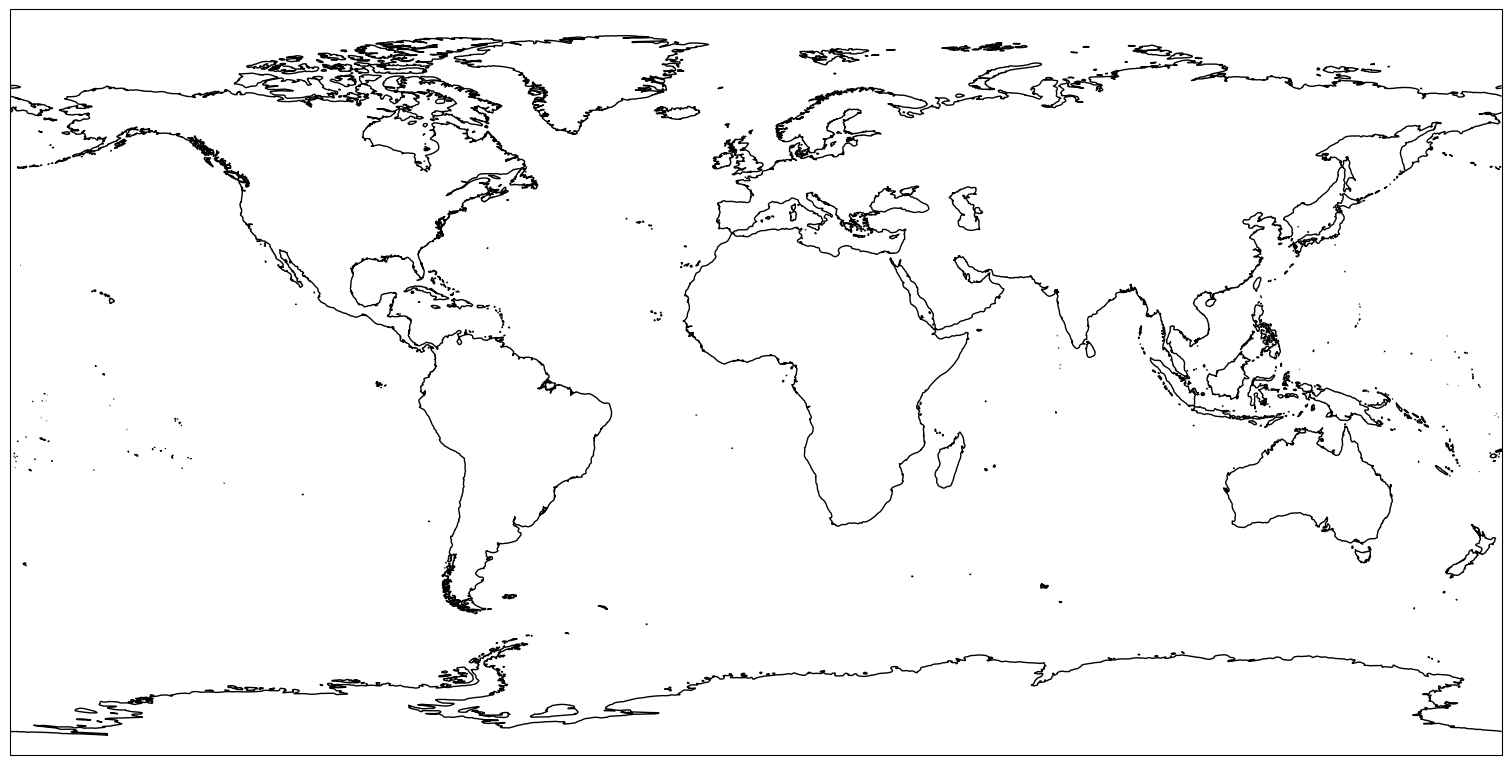

In [11]:
# bbox = [-100, 50, 10, 70]
bbox = [-180, 180, -90, 90]
fig, ax = plt.subplots(
            1,
            1,
            # subplot_kw=dict(projection=ccrs.Mercator()),
            subplot_kw=dict(projection=ccrs.PlateCarree()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines("50m")

In [12]:
import nereus as nr

In [13]:
x, y, lon2, lat2 = nr.projected_grid_to_platecarree_pyproj(bbox, [1000, 500], projection="World_PlateCarree", n_points=100)

In [16]:
distances, inds = nr.create_indexes_and_distances(lon, lat, lon2, lat2, k=1, workers=10)

In [49]:
data_sample = ds['avg_mlotst125'].sel(time='2000-09-01')[0,:].values

radius_of_influence=10000
data_interpolated = data_sample[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

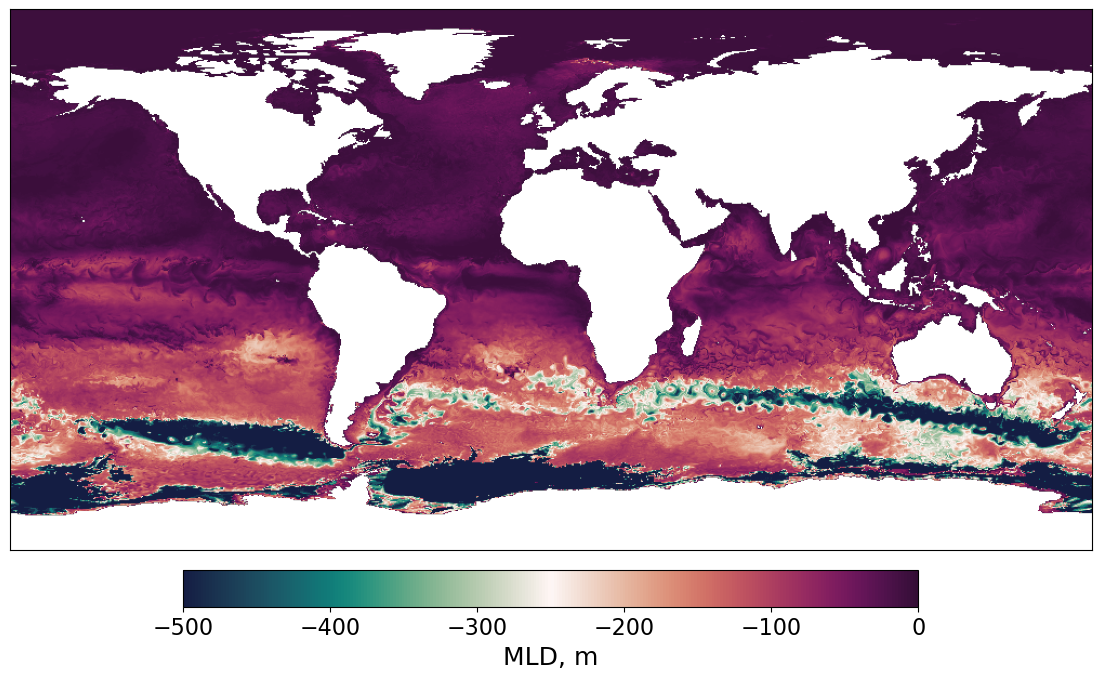

In [50]:
plt.figure(figsize=(15,7))

# Main image
plt.imshow(np.flipud(data_interpolated), vmin=-500, vmax=0, cmap=cmo.curl)

# Remove axis ticks
plt.xticks([])
plt.yticks([])

# Colorbar
cb = plt.colorbar(orientation='horizontal', pad=0.03, shrink=0.5)
cb.ax.tick_params(labelsize=16)  # Increase tick font size
cb.set_label("MLD, m", fontsize=18)  # Add units label

plt.tight_layout()
plt.show()

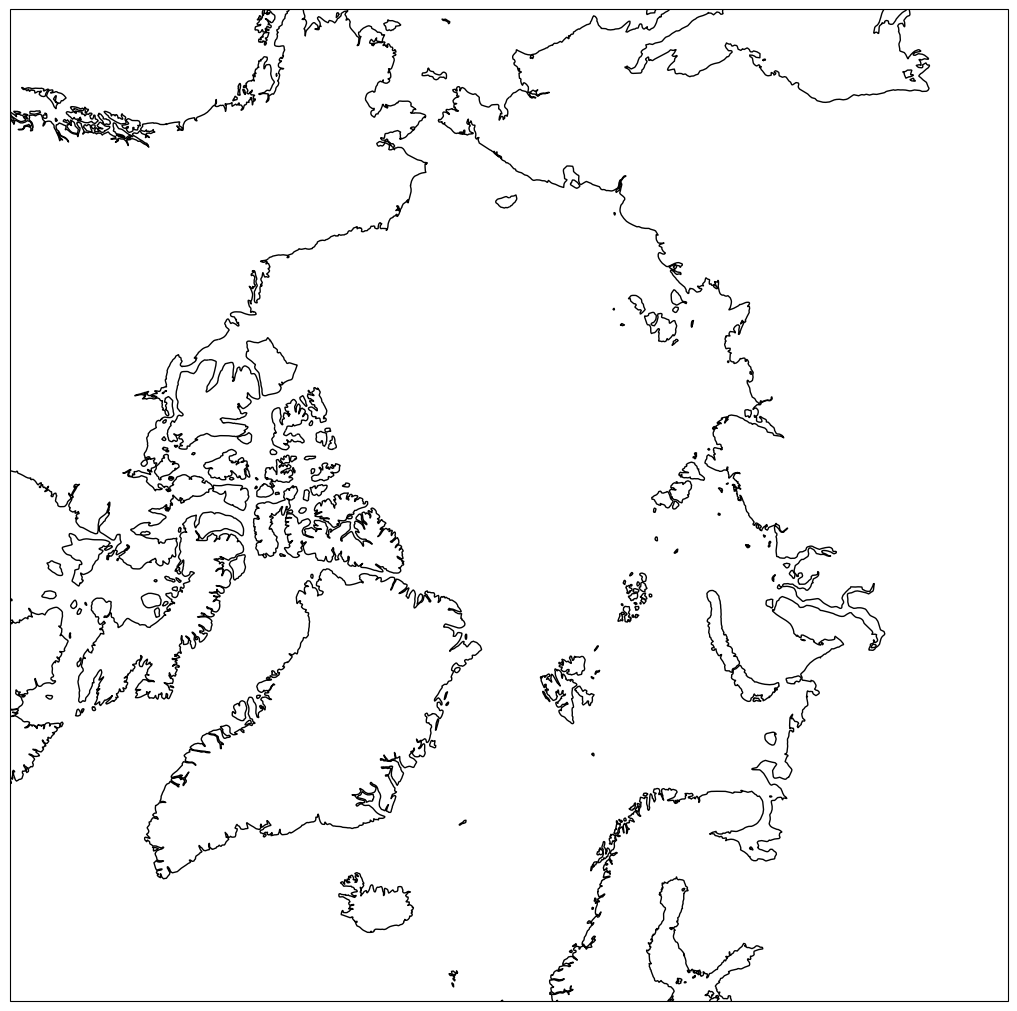

In [51]:
bbox = [-180, 180, 60, 90]
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines()

In [53]:
from pyproj import CRS
custom_north_polar_stereo = CRS.from_string("+proj=stere +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [54]:
x, y, lon2, lat2 = nr.projected_grid_to_platecarree_pyproj(bbox, [500, 500], projection=custom_north_polar_stereo, n_points=100)

In [56]:
distances, inds = nr.create_indexes_and_distances(lon, lat, lon2, lat2, k=1, workers=10)

In [58]:
ds['avg_sisnthick'].sel(time='2000-09-01')

<xarray.DataArray 'avg_sisnthick' (lev: 1, ncells: 7402886)> Size: 30MB
dask.array<getitem, shape=(1, 7402886), dtype=float32, chunksize=(1, 7402886), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 8B 0.0
    time     datetime64[ns] 8B 2000-09-01
Dimensions without coordinates: ncells
Attributes:
    long_name:                    Time-mean snow thickness over sea ice
    units:                        m
    param:                        192.2.10
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  7

In [76]:
data_sample = ds['avg_siconc'].sel(time='2000-03-01')[0,:].values

radius_of_influence=5000
data_interpolated = data_sample[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

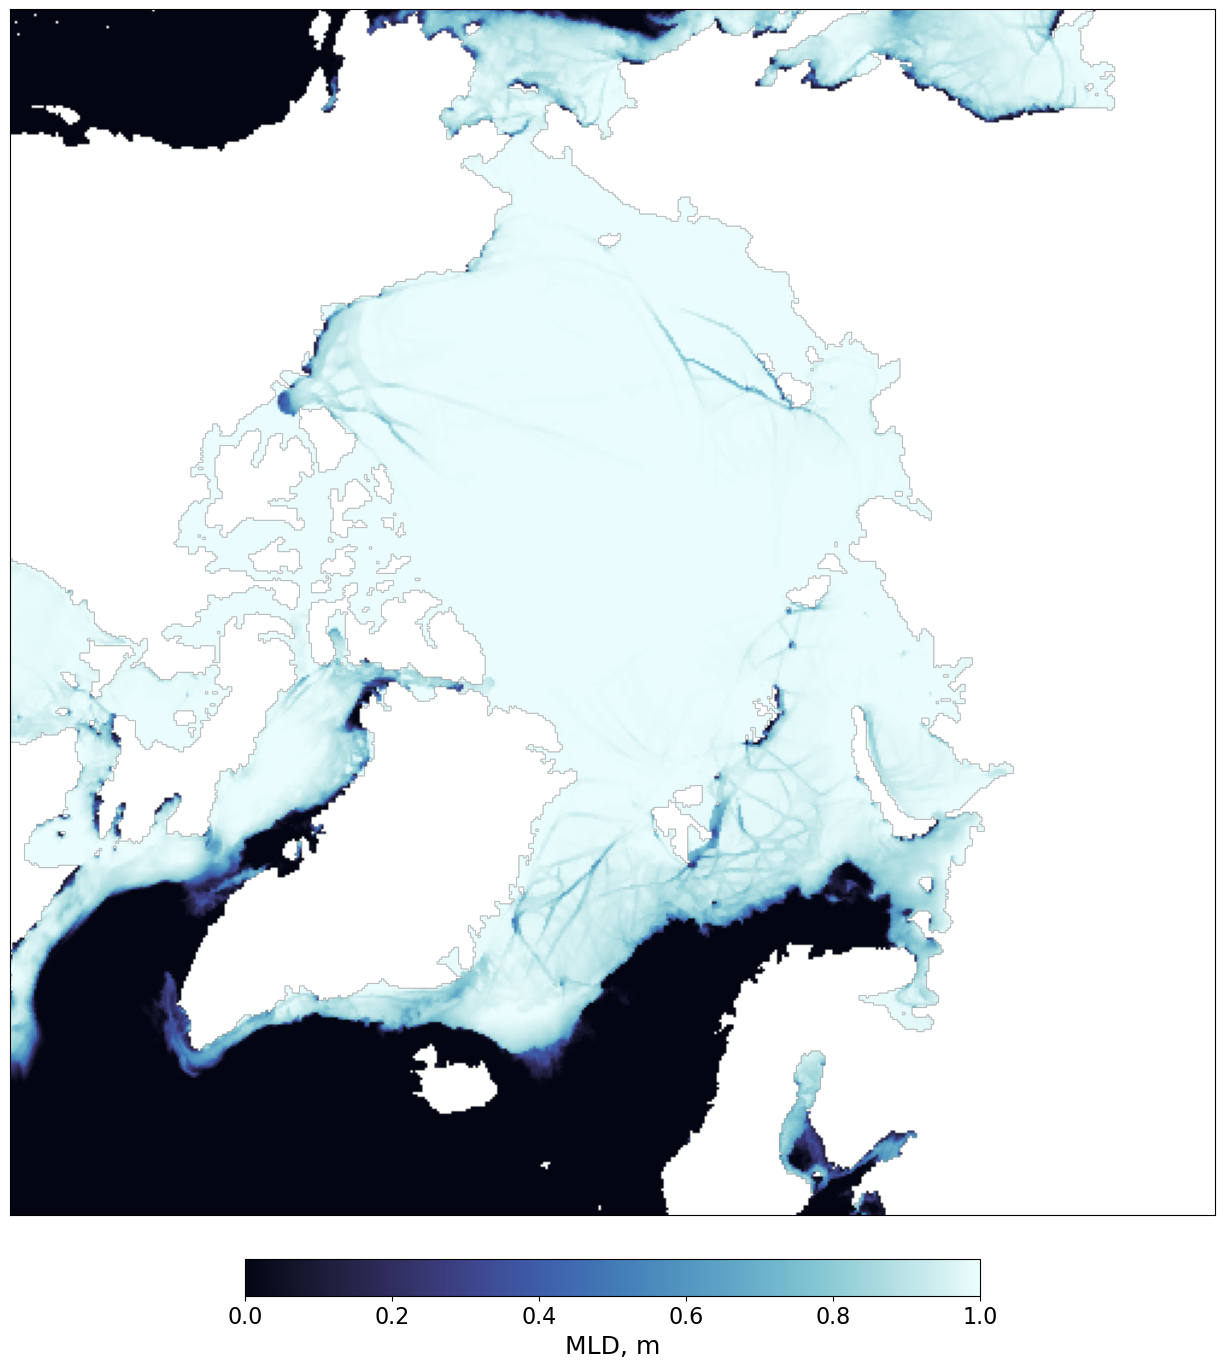

In [77]:
plt.figure(figsize=(15,15))

# Main image
plt.imshow(np.flipud(data_interpolated), vmin=0, vmax=1, cmap=cmo.ice)

# Remove axis ticks
plt.xticks([])
plt.yticks([])

# Colorbar
cb = plt.colorbar(orientation='horizontal', pad=0.03, shrink=0.5)
cb.ax.tick_params(labelsize=16)  # Increase tick font size
cb.set_label("MLD, m", fontsize=18)  # Add units label

plt.tight_layout()
plt.show()